In [1]:
from functools import partial
from itertools import product
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.SimDivFilters import MaxMinPicker
from rdkit import RDLogger
import seaborn as sns
import umap

sys.path.insert(0, '../agenticadmet')
from utils import ECFP_from_smiles, tanimoto_similarity, standardize

[00:38:13] Initializing Normalizer


In [2]:
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

In [3]:
DRAW_OPTIONS = rdMolDraw2D.MolDrawOptions()
DRAW_OPTIONS.baseFontSize = 1.1
# DRAW_OPTIONS.setHighlightColour((1., 1., 0.45, 1))    # yellow
DRAW_OPTIONS.setHighlightColour((0.65, 0.8, 1, 1))    # light blue
DRAW_OPTIONS.highlightRadius = 2
DRAW_OPTIONS.legendFontSize = 40
DRAW_OPTIONS.bondLineWidth = 3.
# DRAW_OPTIONS.padding = 0.05
# DRAW_OPTIONS.fixedScale = 3.

In [ ]:
train = pd.read_csv('../data/asap/train.tsv', sep='\t')
test = pd.read_csv('../data/asap/test.tsv', sep='\t')
train.shape, test.shape

((434, 6), (126, 1))

In [ ]:
train

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9
...,...,...,...,...,...,...
429,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN
430,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN
431,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN
432,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN


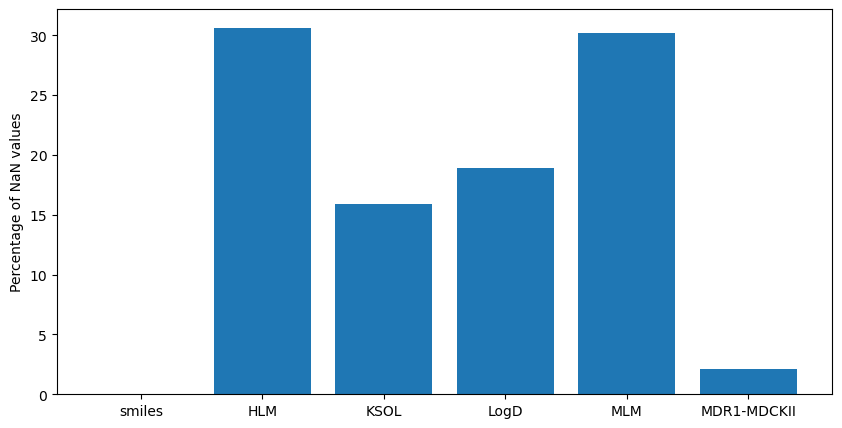

In [6]:
# calculate percentage of nan values in each column
nan_percent = train.isna().sum() / len(train) * 100
nan_percent
# plot a bar plot of the percentage of nan values in each column
plt.figure(figsize=(10, 5))
plt.bar(nan_percent.index, nan_percent.values)
plt.ylabel('Percentage of NaN values')
plt.show()

In [7]:
# percentage of nan values in all columns at the same time except for SMILES
nan_percent = train.iloc[:, 1:].isna().all(axis=1).sum() / len(train) * 100
nan_percent

0.0

In [ ]:
train.describe()

,HLM,KSOL,LogD,MLM,MDR1-MDCKII
count,301.000000,365.000000,352.000000,303.000000,425.000000
mean,124.250432,212.755342,2.205085,176.895215,4.646606
std,217.050726,157.678018,1.228092,318.479175,6.433744
min,0.000000,2.000000,-0.700000,0.000000,0.000000
25%,16.500000,29.000000,1.400000,26.250000,0.900000
50%,48.000000,239.000000,2.200000,72.500000,1.850000
75%,119.000000,374.000000,3.000000,185.000000,5.060000
max,1620.000000,398.000000,4.500000,2380.000000,35.700000


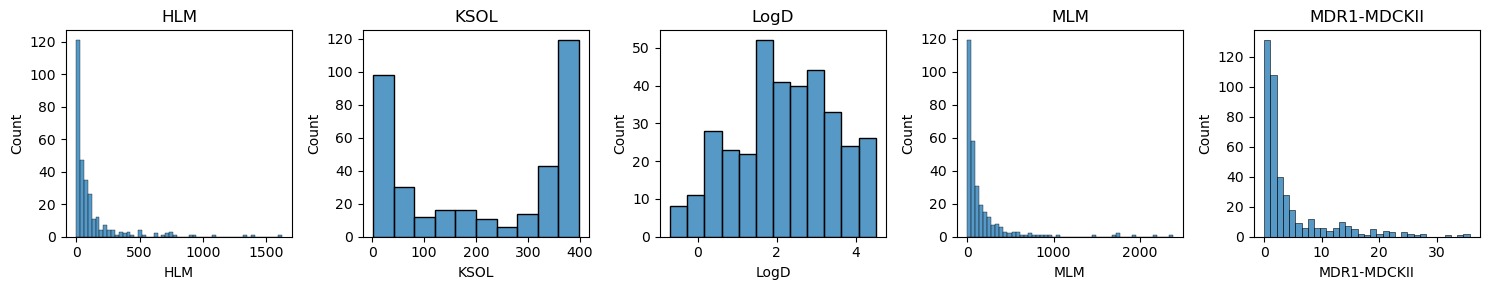

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, col in enumerate(train.columns[1:]):
    sns.histplot(train[col], ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

In [10]:
# Get top 10 smallest values for each property
pd.DataFrame({
    'HLM': train['HLM'].nsmallest(10).values,
    'MLM': train['MLM'].nsmallest(10).values,
    'KSOL': train['KSOL'].nsmallest(10).values, 
    'MDR1-MDCKII': train['MDR1-MDCKII'].nsmallest(10).values
})

,HLM,MLM,KSOL,MDR1-MDCKII
0,0.0,0.0,2.0,0.00000
1,0.0,0.0,2.0,0.00274
2,1.0,0.0,3.0,0.00854
3,1.0,1.0,3.0,0.00871
4,2.0,1.0,3.0,0.00929
5,2.0,1.0,3.0,0.01090
6,2.0,1.0,3.0,0.01420
7,2.0,2.0,3.0,0.02320
8,3.0,2.0,4.0,0.02370
9,3.0,2.0,4.0,0.04480


In [11]:
# By looking at the smallest non-zero values for each property, we can pick a better epsilon for each property
train['LogHLM'] = np.log10(np.clip(train['HLM'], a_min=0.5, a_max=None))
train['LogMLM'] = np.log10(np.clip(train['MLM'], a_min=0.5, a_max=None))
train['LogKSOL'] = np.log10(train['KSOL'])  # no need to clip
train['LogMDR1-MDCKII'] = np.log10(np.clip(train['MDR1-MDCKII'], a_min=0.001, a_max=None))

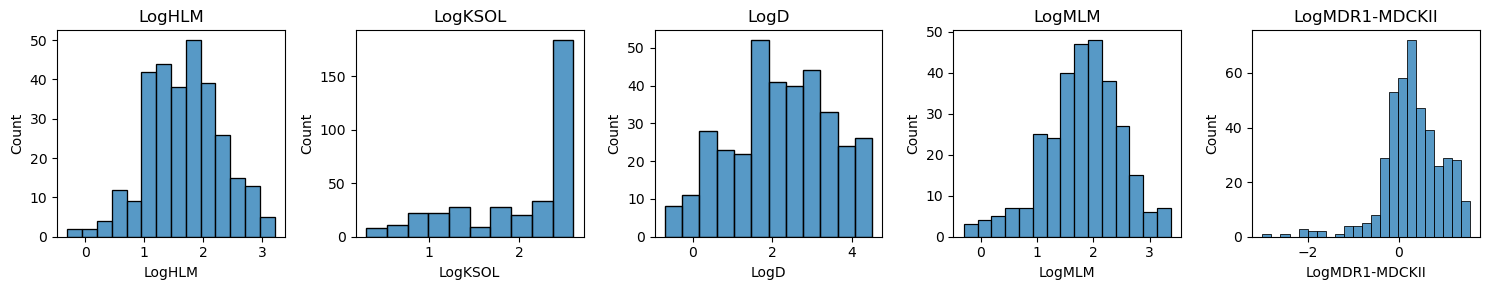

In [12]:
columns = ['LogHLM', 'LogKSOL', 'LogD', 'LogMLM', 'LogMDR1-MDCKII']
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, col in enumerate(columns):
    sns.histplot(train[col], ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

In [13]:
def plot_correlations(data, columns):
    # plot a grid of scatter plots purely with seaborn and add correlation coefficients
    g = sns.PairGrid(data[columns], diag_sharey=False)
    g.map_lower(sns.regplot, scatter_kws={'alpha': 0.5})
    g.map_upper(sns.regplot, scatter_kws={'alpha': 0.5})
    g.map_diag(sns.histplot)

    # iterate over plots and add correlation coefficients as scalar values to the scatter plots
    for (i, col1), (j, col2) in product(enumerate(columns), repeat=2):
        r_coeff = data[col1].corr(data[col2])
        ax = g.axes[i, j]
        ax.text(0.1, 0.9, f'r = {r_coeff:.2f}', 
                ha='left', va='top', 
                transform=ax.transAxes,  # Use axis coordinates
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=0.2),  # Added padding
                color='black', zorder=10)  # Ensure text appears on top

    plt.tight_layout()
    plt.show()

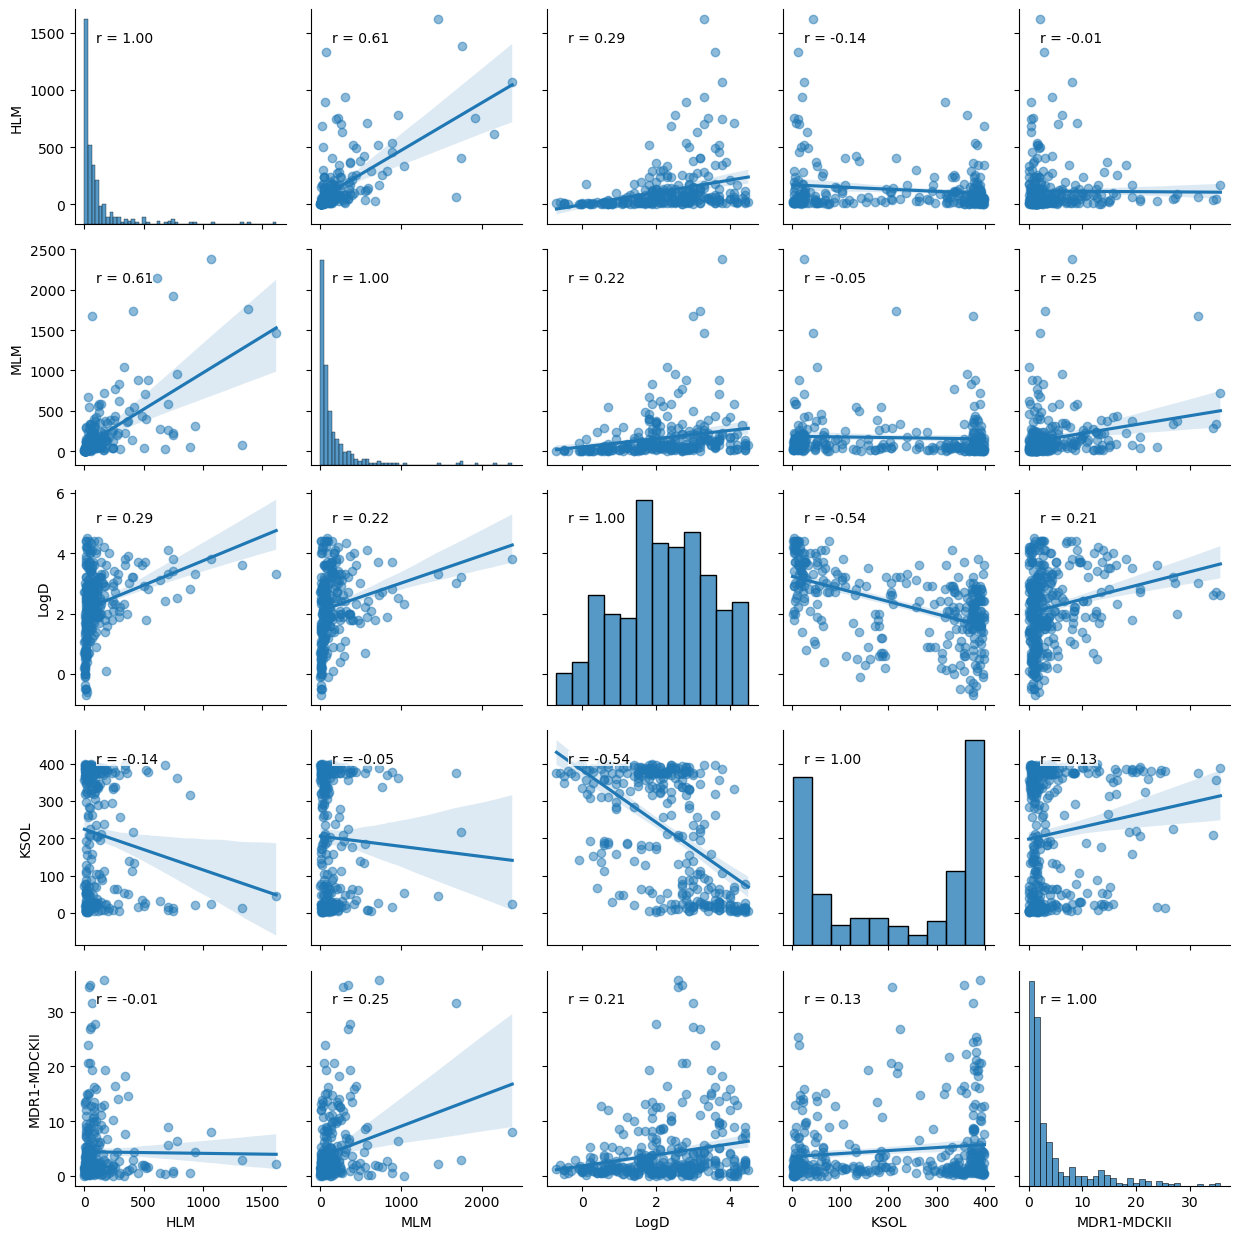

In [14]:
plot_correlations(train, ['HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII'])

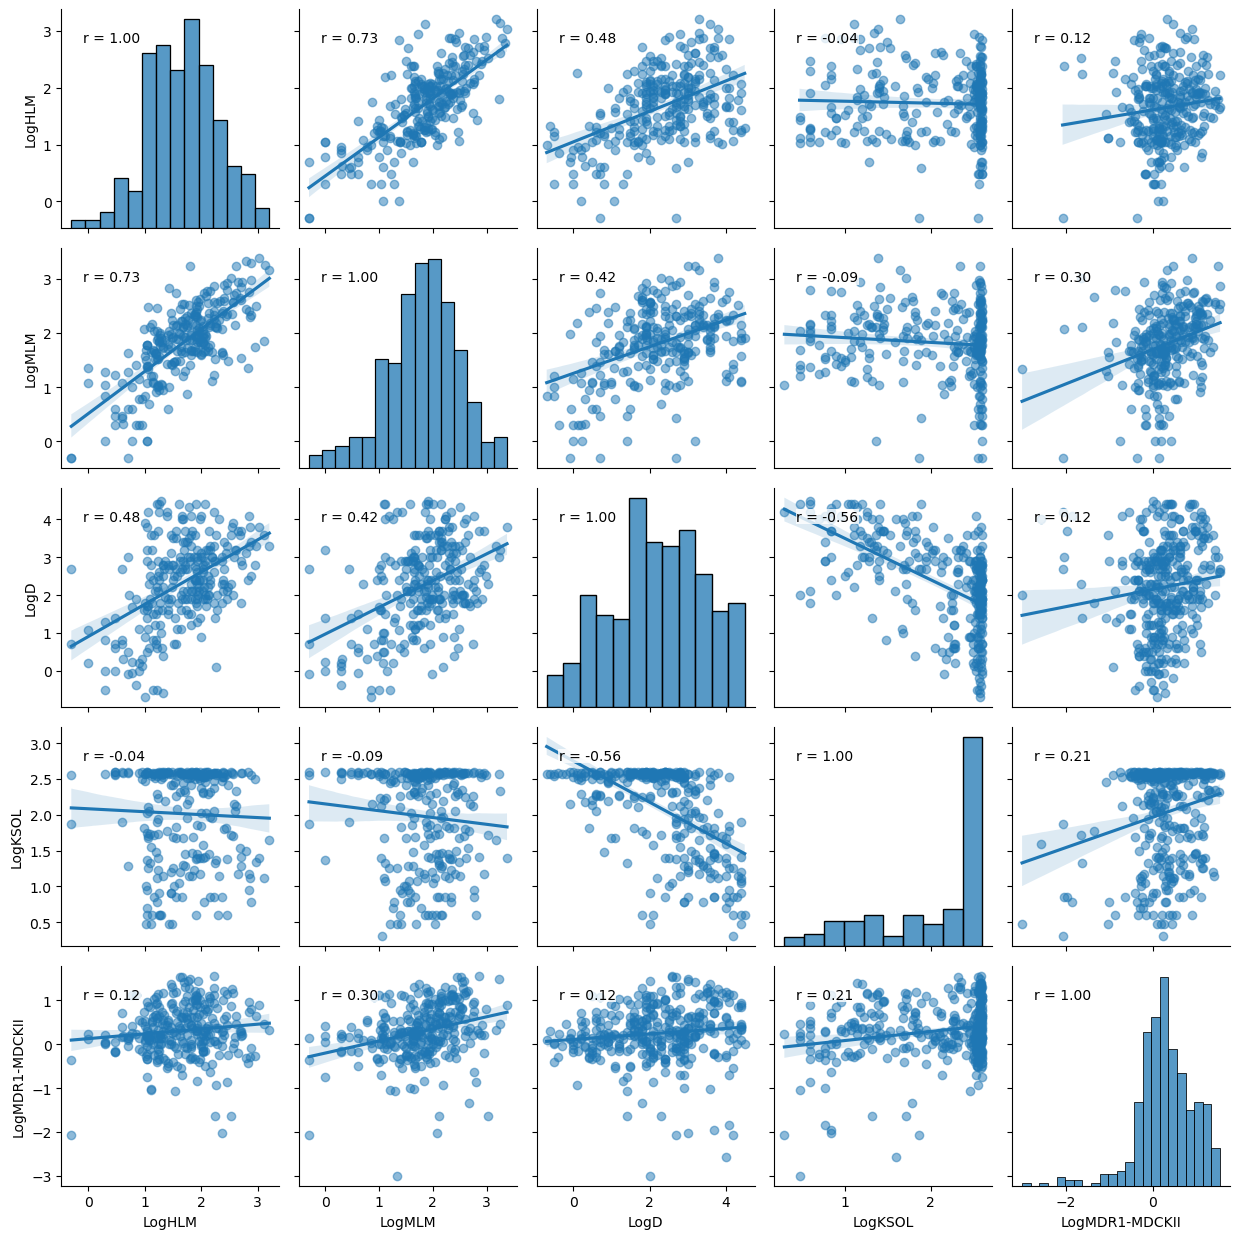

In [15]:
plot_correlations(train, ['LogHLM', 'LogMLM', 'LogD', 'LogKSOL', 'LogMDR1-MDCKII'])

In [16]:
train_ecfp = np.array(train['smiles'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
test_ecfp = np.array(test['smiles'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train_ecfp.shape, test_ecfp.shape

((434, 1024), (126, 1024))

In [17]:
train2test_dist = tanimoto_similarity(train_ecfp, test_ecfp)
train2closest_test_dist = np.max(train2test_dist, axis=1)
test2closest_train_dist = np.max(train2test_dist, axis=0)

train2train_dist = tanimoto_similarity(train_ecfp, train_ecfp)
train2train_dist_mask = np.eye(len(train2train_dist), dtype=bool)
train2train_dist_refined = np.where(train2train_dist_mask, -np.inf, train2train_dist)
train2closest_train_dist = np.max(train2train_dist_refined, axis=1)

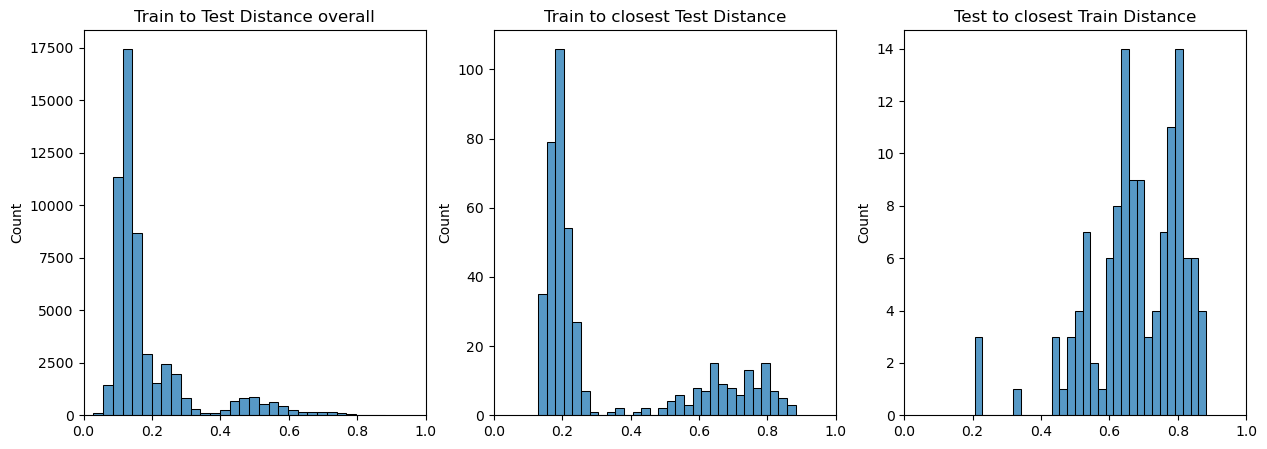

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(train2test_dist.flatten(), ax=ax[0], bins=30)
ax[0].set_title('Train to Test Distance overall');
sns.histplot(train2closest_test_dist, ax=ax[1], bins=30)
ax[1].set_title('Train to closest Test Distance');
sns.histplot(test2closest_train_dist, ax=ax[2], bins=30)
ax[2].set_title('Test to closest Train Distance');
for ax_ in ax:
    ax_.set_xlim(0, 1)

/opt/conda/envs/admet/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/admet/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


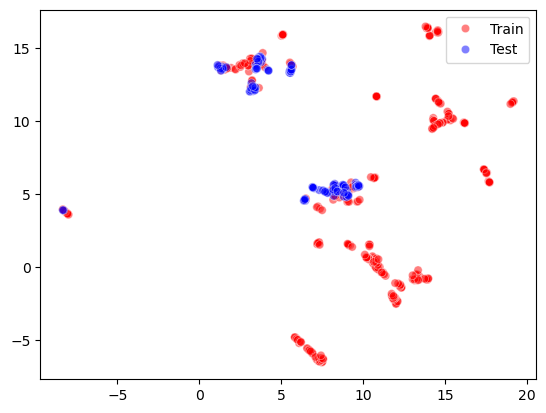

In [19]:
all_ecfp = np.concatenate([train_ecfp, test_ecfp])
all_ecfp_umap = umap.UMAP(
    n_components=2, random_state=42, n_jobs=1, metric='jaccard'
).fit_transform(all_ecfp)
sns.scatterplot(
    x=all_ecfp_umap[:, 0], y=all_ecfp_umap[:, 1], 
    hue=['Train']*len(train) + ['Test']*len(test),
    palette={'Train': 'red', 'Test': 'blue'},
    alpha=0.5
);

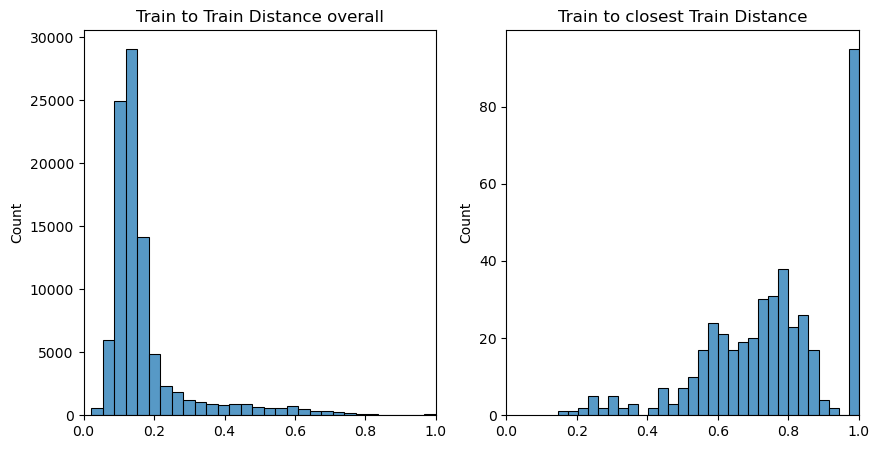

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(train2train_dist[np.triu(np.ones_like(train2train_dist), k=1).astype(bool)], ax=ax[0], bins=30)
ax[0].set_title('Train to Train Distance overall');
sns.histplot(train2closest_train_dist, ax=ax[1], bins=30)
ax[1].set_title('Train to closest Train Distance');
for ax_ in ax:
    ax_.set_xlim(0, 1)

In [21]:
np.isclose(train2closest_train_dist, 1.).sum()

93

In [22]:
identical_idx = np.where(np.isclose(train2train_dist_refined, 1.))
len(identical_idx[0])

156

In [23]:
identical_idx

(array([  9,  29,  29,  31,  31,  33,  48,  48, 223, 247, 247, 249, 249,
        250, 250, 251, 251, 252, 252, 253, 253, 271, 272, 273, 274, 275,
        276, 277, 282, 283, 283, 291, 291, 292, 292, 293, 293, 294, 294,
        295, 295, 299, 300, 300, 302, 303, 304, 304, 305, 306, 306, 310,
        310, 311, 311, 312, 312, 314, 314, 315, 316, 317, 317, 326, 326,
        330, 330, 331, 331, 332, 332, 333, 333, 334, 334, 335, 335, 336,
        336, 337, 337, 338, 338, 339, 339, 341, 342, 345, 345, 346, 346,
        347, 348, 348, 349, 357, 361, 361, 362, 362, 363, 363, 364, 364,
        366, 366, 367, 367, 368, 368, 369, 369, 370, 370, 371, 371, 372,
        372, 373, 373, 375, 375, 377, 377, 378, 378, 379, 380, 380, 381,
        381, 384, 385, 385, 386, 386, 389, 389, 390, 392, 392, 393, 393,
        394, 395, 395, 396, 396, 399, 401, 401, 402, 402, 403, 405, 419]),
 array([ 33,  31,  48,  29,  48,   9,  29,  31, 399, 249, 395, 247, 395,
        251, 389, 250, 389, 253, 372, 252, 372, 2

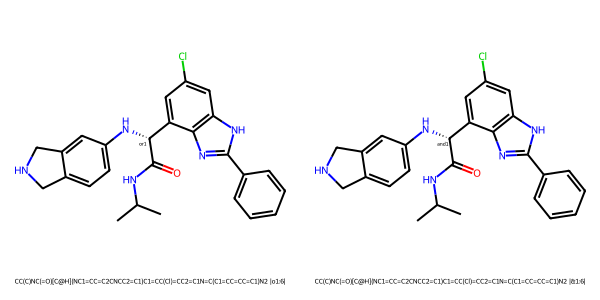

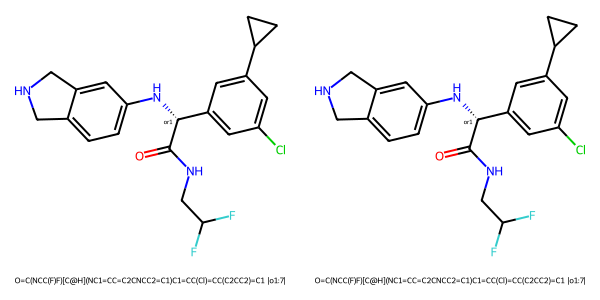

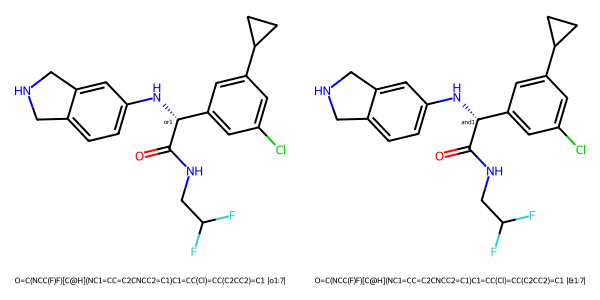

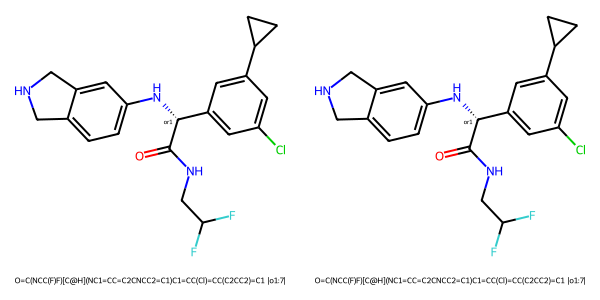

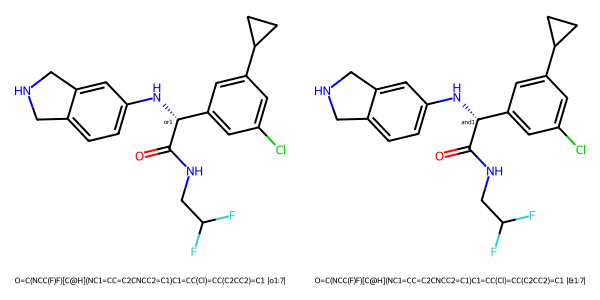

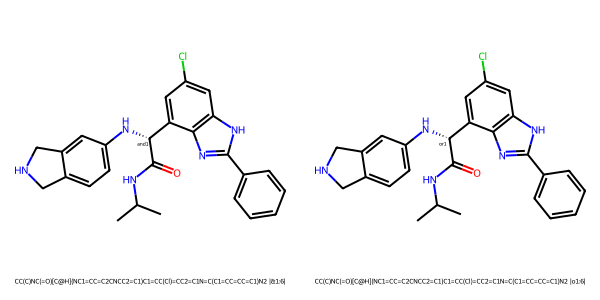

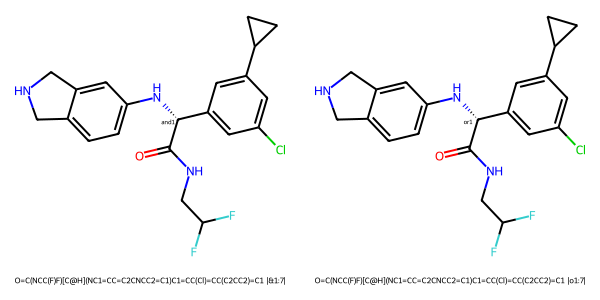

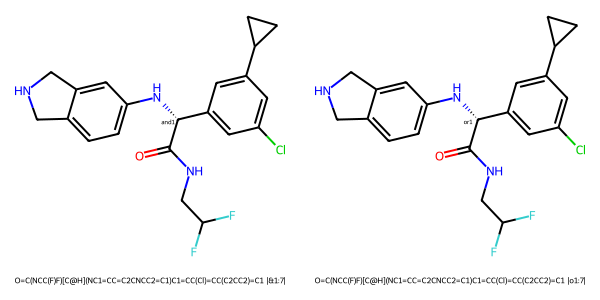

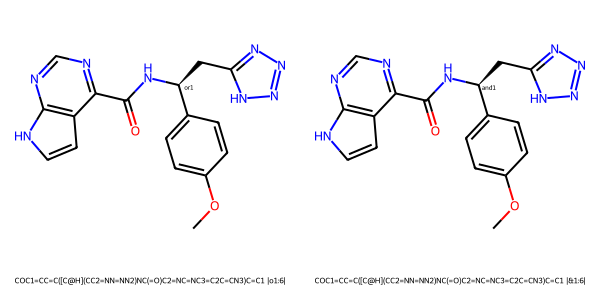

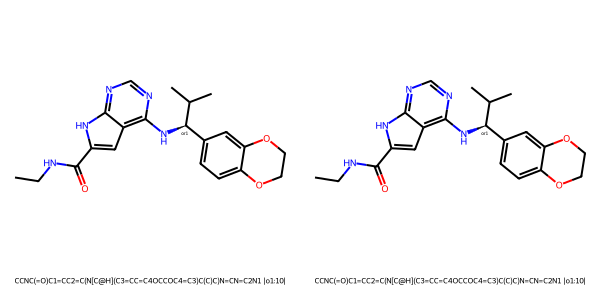

In [24]:
n_to_draw = 10
for i in range(n_to_draw):
    smi1, smi2 = train.iloc[identical_idx[0][i]]['smiles'], train.iloc[identical_idx[1][i]]['smiles']
    mol1, mol2 = Chem.MolFromSmiles(smi1), Chem.MolFromSmiles(smi2)
    img = Draw.MolsToGridImage(
        [mol1, mol2],
        legends=[smi1, smi2],
        molsPerRow=2,
        subImgSize=(300, 300),
        # drawOptions=DRAW_OPTIONS
    )
    display(img)

In [25]:
idx = -1
train.iloc[[identical_idx[0][idx], identical_idx[1][idx]]]

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII
419,CC(C)[C@H](NC1=NC=NC2=C1C=CN2)C1=CC=C2OCCOC2=C...,50.0,224.0,3.2,340.0,26.8,1.69897,2.531479,2.350248,1.428135
403,CC(C)[C@H](NC1=NC=NC2=C1C=CN2)C1=CC=C2OCCOC2=C...,64.0,374.0,3.0,1680.0,31.5,1.80618,3.225309,2.572872,1.498311


## Analyze duplicates ignoring stereochemistry

In [26]:
train['smiles_std'] = train['smiles'].apply(standardize)

In [27]:
train['smiles_std'].isna().sum()

0

In [28]:
print(f"Number of duplicate SMILES in training set: {train[train['smiles_std'].duplicated()]['smiles_std'].nunique()}")

Number of duplicate SMILES in training set: 36


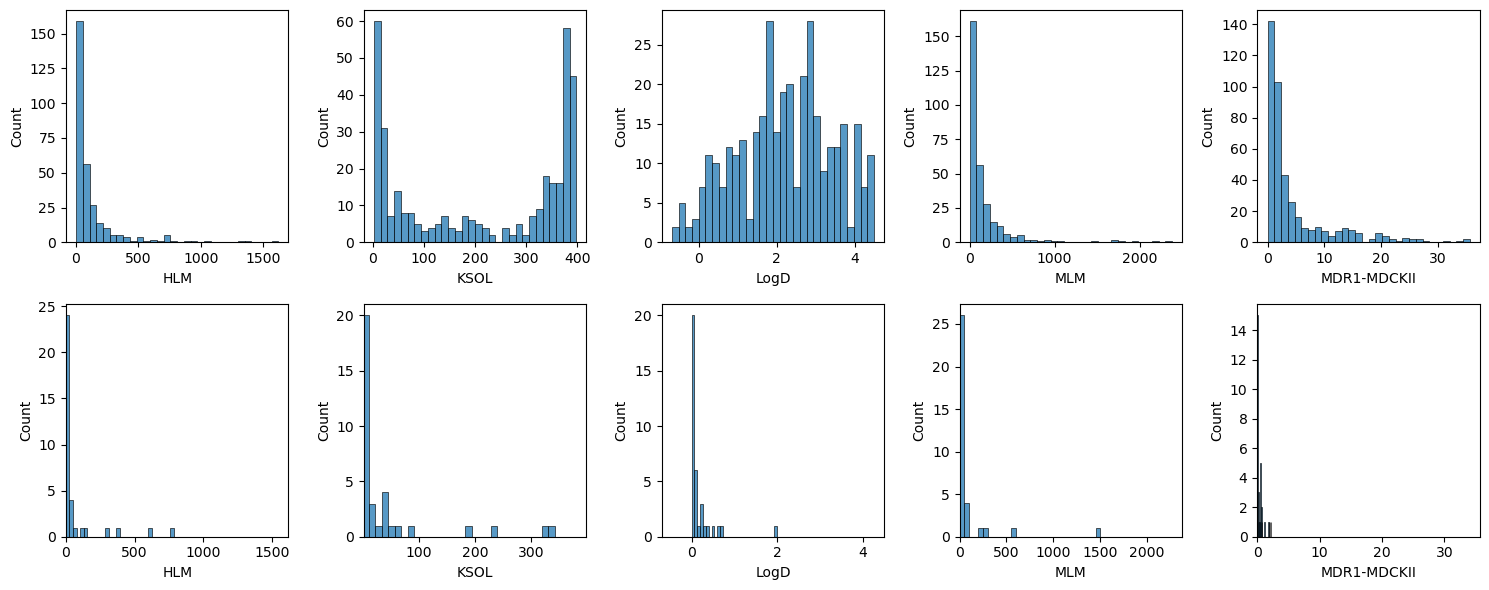

In [29]:
max_diff_in_duplicates = \
    train[train['smiles_std'].duplicated()]\
    .groupby('smiles_std').apply(lambda x: x.iloc[:, 1:].max() - x.iloc[:, 1:].min())
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
# plot original histograms
for i, col in enumerate(train.columns[1:6]):
    sns.histplot(train[col], ax=ax[0, i], bins=30)
# plot histograms of max differences
for i, col in enumerate(max_diff_in_duplicates.columns[:5]):
    sns.histplot(max_diff_in_duplicates[col], ax=ax[1, i], bins=30)
    ax[1, i].set_xlim(train[col].min(), train[col].max())

plt.tight_layout()

## Analyze duplicates accounting for stereochemistry

In [31]:
def standardize_cxsmiles(smiles):
    return Chem.MolToCXSmiles(Chem.MolFromSmiles(smiles))

In [ ]:
train['smiles_std_cx'] = train['smiles'].apply(standardize_cxsmiles)
print(f"Number of duplicate SMILES in training set: {train[train['smiles_std_cx'].duplicated()]['smiles_std_cx'].nunique()}")

Number of duplicate SMILES in training set: 30


In [33]:
train['mol_idx'] = train.groupby('smiles_std_cx').ngroup()

In [35]:
train['smiles_ext'] = train['smiles'].map(lambda smi: smi[smi.index('|'):] if '|' in smi else '')
train[train['smiles_std_cx'].duplicated(keep=False)].sort_values('smiles_std_cx')[
    ['smiles_std_cx', 'mol_idx', 'smiles_ext', 'HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII']
]

,smiles_std_cx,mol_idx,smiles_ext,HLM,MLM,LogD,KSOL,MDR1-MDCKII
300,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,12,|o1:4|,100.0,39.0,3.1,104.0,1.010
294,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,12,|o1:4|,153.0,44.0,3.0,89.0,0.364
336,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,14,|o1:4|,27.0,10.0,2.7,372.0,1.020
346,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,14,|o1:4|,42.0,30.0,2.9,390.0,1.530
293,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3)cc12)c1cc...,30,|o1:3|,169.0,255.0,2.9,111.0,1.180
292,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3)cc12)c1cc...,30,|o1:3|,405.0,140.0,3.2,111.0,1.500
291,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,33,|o1:3|,115.0,81.0,4.4,26.0,1.220
283,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,33,|o1:3|,52.0,147.0,3.4,19.0,2.350
332,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,37,|o1:3|,935.0,311.0,3.3,22.0,4.330
333,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,37,|o1:3|,516.0,709.0,3.7,26.0,1.820


In [36]:
HLM_std, MLM_std, LogD_std, KSOL_std, MDR1_MDCKII_std = \
    train[['HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII']].std()
HLM_std, MLM_std, LogD_std, KSOL_std, MDR1_MDCKII_std

(217.05072622810133,
 318.47917491442934,
 1.2280921175245267,
 157.67801767674385,
 6.433744322214305)

In [37]:
# According to GPT4o, GPT-o3-mini-high and Gemini, the error rate is typically in the following range:
# HLM/MLM: 20-30% of std
# KSOL: 10-20% of std
# LogD: 0.3 log units
# MDR1-MDCKII: 20-30% of std
train['HLM_noisy'] = train.groupby('smiles_std_cx')['HLM'].transform(lambda x: x.max() - x.min() > 0.3 * HLM_std)
train['MLM_noisy'] = train.groupby('smiles_std_cx')['MLM'].transform(lambda x: x.max() - x.min() > 0.3 * MLM_std)
train['LogD_noisy'] = train.groupby('smiles_std_cx')['LogD'].transform(lambda x: x.max() - x.min() > 0.3)
train['KSOL_noisy'] = train.groupby('smiles_std_cx')['KSOL'].transform(lambda x: x.max() - x.min() > 0.2 * KSOL_std)
train['MDR1_MDCKII_noisy'] = train.groupby('smiles_std_cx')['MDR1-MDCKII'].transform(lambda x: x.max() - x.min() > 0.3 * MDR1_MDCKII_std)

In [38]:
train[train['smiles_std_cx'].duplicated(keep=False)].sort_values('smiles_std_cx')[
    [
        'smiles_std_cx', 'mol_idx', 'smiles_ext', 'HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII', 
        'HLM_noisy', 'MLM_noisy', 'LogD_noisy', 'KSOL_noisy', 'MDR1_MDCKII_noisy'
    ]
]

,smiles_std_cx,mol_idx,smiles_ext,HLM,MLM,LogD,KSOL,MDR1-MDCKII,HLM_noisy,MLM_noisy,LogD_noisy,KSOL_noisy,MDR1_MDCKII_noisy
300,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,12,|o1:4|,100.0,39.0,3.1,104.0,1.010,False,False,False,False,False
294,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,12,|o1:4|,153.0,44.0,3.0,89.0,0.364,False,False,False,False,False
336,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,14,|o1:4|,27.0,10.0,2.7,372.0,1.020,False,False,False,False,False
346,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,14,|o1:4|,42.0,30.0,2.9,390.0,1.530,False,False,False,False,False
293,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3)cc12)c1cc...,30,|o1:3|,169.0,255.0,2.9,111.0,1.180,True,True,True,False,False
292,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3)cc12)c1cc...,30,|o1:3|,405.0,140.0,3.2,111.0,1.500,True,True,True,False,False
291,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,33,|o1:3|,115.0,81.0,4.4,26.0,1.220,False,False,True,False,False
283,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,33,|o1:3|,52.0,147.0,3.4,19.0,2.350,False,False,True,False,False
332,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,37,|o1:3|,935.0,311.0,3.3,22.0,4.330,True,True,True,False,True
333,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,37,|o1:3|,516.0,709.0,3.7,26.0,1.820,True,True,True,False,True
